In [2]:
#This Program uses a FCNN Multi-Class Method to classify AT-TPC Images
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from data import load_image_h5
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tensorflow import reshape
import datetime
%load_ext tensorboard
print(tf.__version__)

2.1.0


In [3]:
image_width, image_length, image_channels = 128, 128, 3
image_shape = (128,128,3)

In [4]:
#Takes in dataset (based on https://www.machinecurve.com/index.php/2020/04/13/how-to-use-h5py-and-keras-to-train-with-data-from-hdf5-files/)
dataset = h5py.File('real-xy-labeled-images.h5', 'r')
train_images = dataset['train_features'][...]
train_labels = dataset['train_targets'][...]
test_images = dataset['test_features'][...]
test_labels = dataset['test_targets'][...]
dataset.close()

In [5]:
#Reshape data (https://www.machinecurve.com/index.php/2020/04/13/how-to-use-h5py-and-keras-to-train-with-data-from-hdf5-files/)
train_images = train_images.reshape((len(train_images), image_width, image_length, image_channels))
test_images = test_images.reshape((len(test_images), image_width, image_length, image_channels))

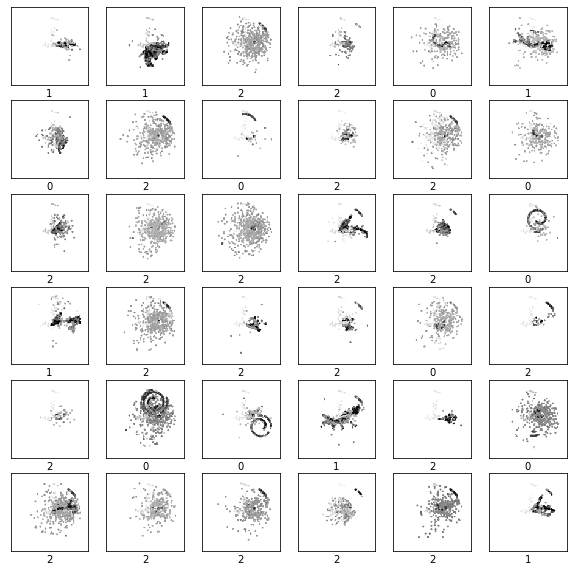

In [6]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()
#0 - proton
#1 - carbon
#2 - other

In [7]:
train_images.shape

(2151, 128, 128, 3)

In [8]:
#Normalize datasets
train_images = 1-(train_images/255.0)
test_images = 1-(test_images/255.0)

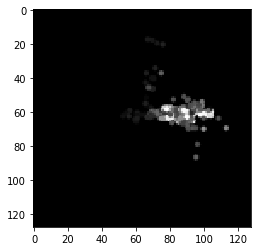

In [9]:
#Shows example image from the train_images
train_images[0]
plt.imshow(train_images[0])

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
#Clear previous runs
!rm -rf ./logs/ 

In [16]:
log_dir = "logs/fit/" + "FCNN" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 0)

In [17]:
FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Flatten(input_shape=(128,128,3)))
FCNN_model.add(layers.Dense(128, activation='relu'))
FCNN_model.add(layers.Dropout(0.5))
FCNN_model.add(layers.Dense(3, activation = 'softmax'))

In [18]:
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [19]:
FCNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 6,291,971
Trainable params: 6,291,971
Non-trainable params: 0
_________________________________________________________________


In [20]:
FCNN_history = FCNN_model.fit(train_images, train_labels,
                    epochs=20,
                    batch_size = 32,
                    shuffle = True,
                    callbacks = [tensorboard_callback],
                    validation_split = 0.3 
                    )

Train on 1505 samples, validate on 646 samples
Epoch 1/20
1505/1505 [==============================] - 2s 1ms/sample - loss: 0.8956 - accuracy: 0.6379 - val_loss: 0.8244 - val_accuracy: 0.6625
Epoch 2/20
1505/1505 [==============================] - 1s 801us/sample - loss: 0.7402 - accuracy: 0.6990 - val_loss: 0.7513 - val_accuracy: 0.6981
Epoch 3/20
1505/1505 [==============================] - 1s 801us/sample - loss: 0.6294 - accuracy: 0.7568 - val_loss: 0.7291 - val_accuracy: 0.7043
Epoch 4/20
1505/1505 [==============================] - 1s 799us/sample - loss: 0.5786 - accuracy: 0.7947 - val_loss: 0.6860 - val_accuracy: 0.7399
Epoch 5/20
1505/1505 [==============================] - 1s 805us/sample - loss: 0.5565 - accuracy: 0.7987 - val_loss: 0.6646 - val_accuracy: 0.7616
Epoch 6/20
1505/1505 [==============================] - 1s 792us/sample - loss: 0.4800 - accuracy: 0.8465 - val_loss: 0.6613 - val_accuracy: 0.7601
Epoch 7/20
1505/1505 [==============================] - 1s 809us/sa

In [21]:
%tensorboard --logdir logs/fit


Reusing TensorBoard on port 6006 (pid 23959), started 23 days, 5:44:07 ago. (Use '!kill 23959' to kill it.)

In [25]:
result = FCNN_model.evaluate(test_images,  test_labels, verbose=2)

538/538 - 0s - loss: 0.5858 - accuracy: 0.7844


In [26]:
predictions = np.argmax(FCNN_model.predict(test_images[:]),axis=1)

In [24]:
predictions.shape

(538,)

In [27]:
predictions[0]

2

In [28]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       133
           1       0.73      0.35      0.48        68
           2       0.80      0.92      0.85       337

    accuracy                           0.78       538
   macro avg       0.76      0.64      0.68       538
weighted avg       0.78      0.78      0.77       538

